In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [0]:
%tensorflow_version 2.x

In [3]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [4]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git 

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-f8s21pbr
  Running command git clone -q https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-f8s21pbr
  Created wheel for tfdiffeq: filename=tfdiffeq-0.0.1-py2.py3-none-any.whl size=46082 sha256=2eb82f2932ff672b3ea943ab4a17c4386e526074e9c8ccd3443b6a694b5e1318
  Stored in directory: /tmp/pip-ephem-wheel-cache-4omoo8qw/wheels/1a/fc/26/608bd5ecbf21d23b0e87bb71814d3c031b7c8a5b37fa7aa904
Successfully built tfdiffeq


In [5]:
!pip install pysindy

In [6]:
!pip install tensorflow_probability

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results

In [0]:
NUM_SAMPLES = 1000
device = 'cpu:0' # These experiments do not require the GPU. Normally, 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' should be used.

# Force Float 64
tf.keras.backend.set_floatx('float64')

In [0]:
class LotkaVoltera(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.b, self.c, self.d = a, b, c, d
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)
    
    dR_dT = self.a * r - self.b * r * f
    dF_dT = -self.c * f + self.d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

In [12]:
%%time

with tf.device(device):
  result = odeint(LotkaVoltera(a, b, c, d), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 2.47 s, sys: 53 ms, total: 2.52 s
Wall time: 2.68 s


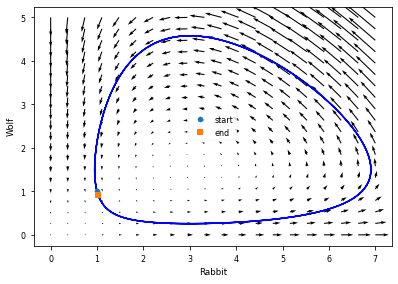

In [13]:
lims = [0, 5]
plot_phase_portrait(LotkaVoltera(a, b, c, d), xlabel='Rabbit', ylabel='Wolf', xlims=[0, 7], ylims=lims)
plot_vector_field(result, xlabel='Rabbit', ylabel='Wolf')

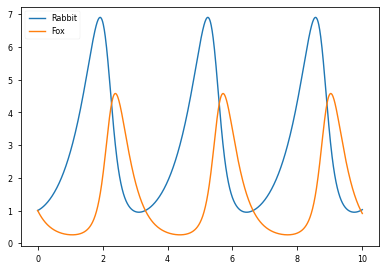

In [14]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

# Universal ODEs

Original Lotke-Volterra system 
>$\frac{\partial R}{\partial T} = aR - bRF \\ \frac{\partial F}{\partial T} = -cF + dRF$

For our system, we set $a=1.5$, $b=1$, $c=3.0$, $d=1$

-------

For Universal ODE formulation of the above,

> We substitute $bRF$ with $U_1(R, F)$ in $\frac{\partial R}{\partial T}$.

> We substitute $bRF$ with $U_2(R, F)$ in $\frac{\partial F}{\partial T}$.

Therefore,
>$\frac{\partial R}{\partial T} = aR - U_1(R, F) \\ \frac{\partial F}{\partial T} = -cF + U_2(R, F)$


In [0]:
class LotkaVolteraTrainable(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.c = a, c

    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(2,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(2, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 2]))  # [1, 2] -> [1, 2]
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    
    dR_dT = self.a * r - pred1
    dF_dT = -self.c * f + pred2
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t_train = tf.linspace(0., 2., num=30)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

epochs = 100
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

In [17]:
# Lets see the ground truth sample
%%time

with tf.device(device):
  result_train = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)
  
print("Finished integrating ! Result shape : ", result_train.shape)

Finished integrating ! Result shape :  (30, 2)
CPU times: user 340 ms, sys: 10.5 ms, total: 350 ms
Wall time: 341 ms


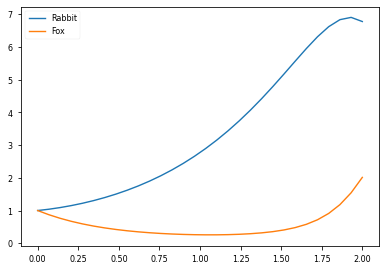

In [18]:
plot_results(t_train, result_train, labels=['Rabbit', 'Fox'])

# Train a model

We pretrain the model for a few epochs to reduce the loss quickly, and then retrain the model using BFGS to reduce the loss to a small enough tolerance (say $10^{-6}$).

In [20]:
%%time

with tf.device(device):
  model = LotkaVolteraTrainable(a, b, c, d)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

Computing ground truth...
Ground truth shape : (30, 2)
Epoch 1
Loss : 10.992634101706493
LR : 0.0099309245

Epoch 2
Loss : 4.200225213023328
LR : 0.009862327

Epoch 3
Loss : 0.7407070546376819
LR : 0.009794203

Epoch 4
Loss : 0.22377207009365144
LR : 0.0097265495

Epoch 5
Loss : 0.9104148394192274
LR : 0.009659363

Epoch 6
Loss : 1.368997969723929
LR : 0.009592641

Epoch 7
Loss : 1.3299152238527217
LR : 0.009526379

Epoch 8
Loss : 0.9556125034466085
LR : 0.009460577

Epoch 9
Loss : 0.4801544013542277
LR : 0.009395227

Epoch 10
Loss : 0.13999975437102335
LR : 0.0093303295

Epoch 11
Loss : 0.10990302449944243
LR : 0.00926588

Epoch 12
Loss : 0.35970250842893114
LR : 0.009201876

Epoch 13
Loss : 0.5667594043917034
LR : 0.009138315

Epoch 14
Loss : 0.5213719597003306
LR : 0.009075192

Epoch 15
Loss : 0.32512128353867525
LR : 0.0090125045

Epoch 16
Loss : 0.1450387344196678
LR : 0.00895025

Epoch 17
Loss : 0.06361208447781926
LR : 0.008888427

Epoch 18
Loss : 0.07668079875105036
LR : 0.0088

In [0]:
model.save_weights('model_weights/ckpt', save_format='tf')

In [22]:
model.load_weights('model_weights/ckpt')

## Finetune the model with BFGS

In [0]:
from tfdiffeq.bfgs_optimizer import BFGSOptimizer

In [0]:
tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

### Create a wrapper function for the BFGS optimizer 

BFGS optimizer is somewhat different than SGD or ADAM from Tensorflow. It requires a callable function `loss_func`, which accepts the `model` as input and returns a single float value `loss_value`.

```python
loss_value = loss_func(model)
```

The model is generally a `tf.keras.Model` or its subclasses, and we can use external data as inputs if required to obtain a loss value as shown below.

In [0]:
from tfdiffeq.adjoint import odeint as adjoint_odeint

def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [26]:
%%time

model = bfgs_optimizer.minimize(loss_wrapper, model)

Iter: 1 loss: 0.041287675417741442
Iter: 2 loss: 0.040494851699277988
Iter: 3 loss: 0.0392374732155567
Iter: 4 loss: 0.039216343721603625
Iter: 5 loss: 5.0608730955277137
Iter: 6 loss: 0.039004600662469059
Iter: 7 loss: 0.037499866244456573
Iter: 8 loss: 0.025839098787138828
Iter: 9 loss: 3.1833113244888369
Iter: 10 loss: 0.02583329492460559
Iter: 11 loss: 0.029147451906736586
Iter: 12 loss: 0.020963379046887009
Iter: 13 loss: 0.029232031728844025
Iter: 14 loss: 0.020058591162195324
Iter: 15 loss: 0.0236167783311912
Iter: 16 loss: 0.018169629485614867
Iter: 17 loss: 0.018463138479389084
Iter: 18 loss: 0.015142018939913958
Iter: 19 loss: 0.011035538539640658
Iter: 20 loss: 0.010389829101748859
Iter: 21 loss: 0.067523287712635
Iter: 22 loss: 0.010193535473714222
Iter: 23 loss: 0.0093534463163813218
Iter: 24 loss: 0.00908923345372598
Iter: 25 loss: 0.0098177674546017987
Iter: 26 loss: 0.0076787192124451219
Iter: 27 loss: 0.0045401696221174272
Iter: 28 loss: 0.061093035100257917
Iter: 29 l

# Save your weights and download them !

In [0]:
model.save_weights('model_weights/ckpt', save_format='tf')

# Load a new model and load these weights (if you didnt train above)

In [0]:
import os
import requests

def get_checkpoints():
  if not os.path.exists('model_weights'):
      os.makedirs('model_weights')

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/checkpoint')
  with open('./model_weights/checkpoint', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.data-00000-of-00001')
  with open('./model_weights/ckpt.data-00000-of-00001', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.index')
  with open('./model_weights/ckpt.index', 'wb') as f:
    f.write(r.content)
  
  print("Pretrained checkpoints retrieved !")

In [29]:
get_checkpoints()

Pretrained checkpoints retrieved !


In [30]:
model = LotkaVolteraTrainable(a, b, c, d)
model.load_weights('model_weights/ckpt')

# Lets interpolate with our approximate universal ODE !

With a trained Neural ODE that appxoximates the Lotka Voltera system with just 30 samples, lets interpolate within the same timeframe to get a fine solution to the coarse approximate.

In [31]:
%%time

t_eval = tf.linspace(0., 2, num=1000)  # Re-evaluate for just 2 seconds of input, but 1000 timesteps

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states, t_eval)

CPU times: user 1.88 s, sys: 13.8 ms, total: 1.9 s
Wall time: 1.87 s


# Plot the ODE approximation !

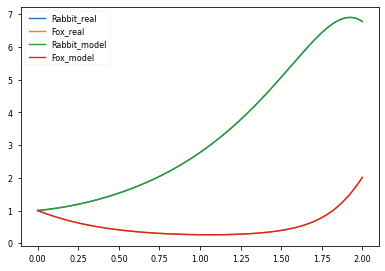

In [32]:
plot_results(t_eval, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_eval, model_results, labels=['Rabbit_model', 'Fox_model'])

# Lets try and obtain the underlying equations of this system

In [0]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [0]:
from pysindy import SINDy
from pysindy import SR3
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import this optimizer for Ridge regression !
from tfdiffeq.sindy_utils import STRRidge

# Optimize hyper parameters of SRTRidge and the Polynomial Library

In [0]:
# sindy_optm = SRTRidge(threshold=0.5, alpha=1.0)
sindy_optm = SR3(threshold=0.1, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=10, include_interaction=True,  interaction_only=True)

# Lets fit the SInDy model !

SInDy is short for "Sparse Identification of Non-linear Dynamical Systems" from the paper [Discovering governing equations from data by sparse identification of nonlinear dynamical systems](https://www.pnas.org/content/113/15/3932)

In [36]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

SINDy(differentiation_method=<pysindy.differentiation.finite_difference.FiniteDifference object at 0x7f51ae6ce6a0>,
      discrete_time=False,
      feature_library=PolynomialLibrary(degree=10, include_bias=True,
                                        include_interaction=True,
                                        interaction_only=True, order='C'),
      feature_names=['x0', 'x1'], n_jobs=1,
      optimizer=SR3(copy_X=True, fit_intercept=False, max_iter=100,
                    normalize=False, nu=1.0, threshold=0.1, thresholder='l0',
                    tol=1e-05))

# Lets compare with the original equations

>$\frac{\partial R}{\partial T} = aR - bRF \\ \frac{\partial F}{\partial T} = -cF + dRF$

Recall, $a=1.5$, $b=1$, $c=3.0$, $d=1$

We substitute $bRF$ with $U_1(R, F)$ in $\frac{\partial R}{\partial T}$.

We substitute $bRF$ with $U_2(R, F)$ in $\frac{\partial F}{\partial T}$.

--------

We compare the above two equations with the one printed below.

We get $a'=1.498$ which is quite close to $a=1.5$, $c'=2.993$, close to the original $c=3.0$.

The equation below approximates $b'=0.997$, close to the $b=1$ we expect. $d'=0.999$ is a closer approximate to our original $d=1$.



In [37]:
sindy_model.print()

x0' = 1.498 x0 + -0.997 x0 x1
x1' = -2.993 x1 + 0.999 x0 x1


In [38]:
sindy_model.coefficients()

array([[ 0.        ,  1.49801949,  0.        , -0.99657202],
       [ 0.        ,  0.        , -2.99258126,  0.99857371]])

In [39]:
sindy_model.equations()

['1.498 x0 + -0.997 x0 x1', '-2.993 x1 + 0.999 x0 x1']

# Compute the $R^2$ score 

In [40]:
sindy_model.score(model_preds_np, t_eval_np)

0.9999294566666135

# Finding the correct coefficients for the model

We have the ode framework components which correspond to the neural network modules, but we cant be sure that the parameters found are correctly found by SInDy.

We can refit the model (but now replacing correct components and removing the corresponding neural network component), and try to estimate the parameters from the train set.

In [0]:
class LotkaVolteraParameters(tf.keras.Model):
  
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    
    # Can also initialize with the values found above for much faster convergence !
    # self.parameters = tf.Variable([1.498, 0.997, 2.993, 0.999], dtype=tf.float64)
    self.parameters = tf.Variable(tf.random.uniform(shape=[4], dtype=tf.float64))
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    # Apply abs, because we want to ensure these parameters are > 0
    params = tf.math.abs(self.parameters)
    a, b, c, d = tf.unstack(params)
    
    dR_dT = a * r - b * r * f
    dF_dT = -c * f + d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t_train = tf.linspace(0., 2., num=30)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

epochs = 25
initial_learning_rate = 0.1
decay_steps = 100
decay_rate = 0.5

In [43]:
%%time

with tf.device(device):
  model = LotkaVolteraParameters()

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

Computing ground truth...
Ground truth shape : (30, 2)
Epoch 1
Loss : 5.131285589600938
LR : 0.09930925

Epoch 2
Loss : 4.303921480640789
LR : 0.09862327

Epoch 3
Loss : 3.4453021057177344
LR : 0.09794203

Epoch 4
Loss : 2.53475530333001
LR : 0.0972655

Epoch 5
Loss : 1.5829151808680677
LR : 0.09659363

Epoch 6
Loss : 1.3064334620214877
LR : 0.09592641

Epoch 7
Loss : 0.9324396946964507
LR : 0.0952638

Epoch 8
Loss : 0.5253288384566731
LR : 0.094605766

Epoch 9
Loss : 0.22677009883334368
LR : 0.093952276

Epoch 10
Loss : 0.19491807516291765
LR : 0.0933033

Epoch 11
Loss : 0.4522553016865399
LR : 0.09265881

Epoch 12
Loss : 0.6727868668181067
LR : 0.09201877

Epoch 13
Loss : 0.5703617293845564
LR : 0.09138315

Epoch 14
Loss : 0.2882086806664751
LR : 0.090751916

Epoch 15
Loss : 0.1018834061838672
LR : 0.09012505

Epoch 16
Loss : 0.14144614704281383
LR : 0.089502506

Epoch 17
Loss : 0.30309522541398043
LR : 0.08888427

Epoch 18
Loss : 0.387262619459112
LR : 0.0882703

Epoch 19
Loss : 0.3

In [0]:
tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [0]:
def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [46]:
model = bfgs_optimizer.minimize(loss_wrapper, model)

Iter: 1 loss: 0.19037971791400043
Iter: 2 loss: 7.5809400878738309
Iter: 3 loss: 7.2664869212974956
Iter: 4 loss: 4.5374354808123316
Iter: 5 loss: 1.485828271461
Iter: 6 loss: 0.19868456432738371
Iter: 7 loss: 0.10172178783827857
Iter: 8 loss: 7.1596354029101539
Iter: 9 loss: 0.09915243597269062
Iter: 10 loss: 2.8009774450042912
Iter: 11 loss: 0.19581139730851602
Iter: 12 loss: 0.084822440847361472
Iter: 13 loss: 0.55315463979379231
Iter: 14 loss: 0.078742003773469751
Iter: 15 loss: 0.11895972442669572
Iter: 16 loss: 0.068080299843072262
Iter: 17 loss: 0.06624039083542875
Iter: 18 loss: 0.058775195780415311
Iter: 19 loss: 0.052119997832502624
Iter: 20 loss: 0.087363348451291983
Iter: 21 loss: 0.050449600681711525
Iter: 22 loss: 0.039193476961317392
Iter: 23 loss: 0.10556207351628887
Iter: 24 loss: 0.03581395292983644
Iter: 25 loss: 0.024543633421660278
Iter: 26 loss: 0.37927917017948387
Iter: 27 loss: 0.024330390069166048
Iter: 28 loss: 0.014685770556346216
Iter: 29 loss: 0.03461437843

## Lets print the learned parameters of this ODE

In [47]:
params = tf.math.abs(model.trainable_variables[0])
params.numpy().tolist()

[1.4999991388905172, 0.999996220820509, 2.9999761581124833, 0.9999915705361759]

# Finally, lets extrapolate the derived ODE !

In [48]:
%%time

a_dash = 1.4999991388905172
b_dash = 0.9999962208205090
c_dash = 2.9999761581124833
d_dash = 0.9999915705361759

t_extrapolate = tf.linspace(0., 10.0, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = LotkaVoltera(a_dash, b_dash, c_dash, d_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states_extrapolate, t_extrapolate)

CPU times: user 4.49 s, sys: 82.5 ms, total: 4.57 s
Wall time: 4.44 s


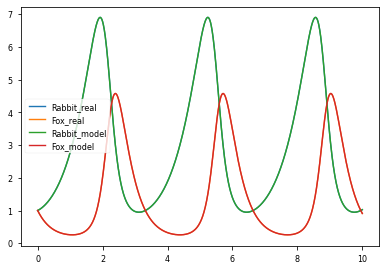

In [49]:
plot_results(t_extrapolate, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_extrapolate, extrapolated_results, labels=['Rabbit_model', 'Fox_model'])